<a href="https://colab.research.google.com/github/tashfeenMustafa/PCA-Image-Audio-Text-Data/blob/main/DataMining_FinalProject_GTZAN_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with the GTZAN Dataset (audio files)

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Implementing calculation of MFCC and Filter banks

In [ ]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal as sps
from io import BytesIO

def reSampleSignal(sample_rate, signal):
  new_sample_rate = 1000

  # Resample data
  number_of_samples = round(len(signal) * float(new_sample_rate) / sample_rate)
  resampled_signal = sps.resample(signal, number_of_samples)
  return new_sample_rate, resampled_signal

def preEmphasis(signal):
  pre_emphasis = 0.90
  emphasized_signal = np.append(signal, signal[1:] - pre_emphasis * signal[:-1])
  return emphasized_signal

def framing(emphasized_signal, sample_rate):
  # in seconds
  frame_size = 0.050
  # in seconds
  frame_stride = 0.025

  # Converting seconds to samples
  frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

  # Calculating the number of frames required
  signal_length = len(emphasized_signal)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(emphasized_signal, z)

  # Create indices for frames and create the frames
  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  frames = pad_signal[indices.astype(np.int32, copy=False)]

  return frame_length, frames

def applyWindowFunction(frame_length, frames):
  frames *= np.hamming(frame_length)
  return frames

def fourierTransformAndPowerSpectrum(frames, NFFT):
  # compute power spectrum (periodogram)
  mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
  pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))  # Power Spectrum

  return mag_frames, pow_frames

def computeFilterBanks(sample_rate, NFFT, pow_frames):
  nfilt = 40

  low_freq_mel = 0
  high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
  hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
  bin_ = np.floor((NFFT + 1) * hz_points / sample_rate)

  fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

  for m in range(1, nfilt + 1):
      f_m_minus = int(bin_[m - 1])   # left
      f_m = int(bin_[m])             # center
      f_m_plus = int(bin_[m + 1])    # right

      for k in range(f_m_minus, f_m):
          fbank[m - 1, k] = (k - bin_[m - 1]) / (bin_[m] - bin_[m - 1])
      for k in range(f_m, f_m_plus):
          fbank[m - 1, k] = (bin_[m + 1] - k) / (bin_[m + 1] - bin_[m])

  filter_banks = np.dot(pow_frames, fbank.T)
  filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
  filter_banks = 20 * np.log10(filter_banks)  # dB

  return filter_banks

def getMFCC(filter_banks):
  num_ceps = 39

  mfcc = dct(filter_banks, type=1, axis=1, norm='ortho')[:, 1: (num_ceps + 1)]  # Keep keeping all 39 cepstral coefficients
  return mfcc

def dataNormalization(mfcc, filter_banks):
  filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
  mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
  
  return mfcc, filter_banks

def getMFCCandFilterBanks(file_name):
  file_name = file_name
  sample_rate, signal = scipy.io.wavfile.read(file_name)
  signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

  NFFT = 512

  sample_rate, resampled_signal = reSampleSignal(sample_rate, signal)
  emphasized_signal = preEmphasis(resampled_signal)
  frame_length, frames = framing(emphasized_signal, sample_rate)

  frames = applyWindowFunction(frame_length, frames)

  mag_frames, pow_frames = fourierTransformAndPowerSpectrum(frames, NFFT)

  filter_banks = computeFilterBanks(sample_rate, NFFT, pow_frames)
  mfcc = getMFCC(filter_banks)
  mfcc, filter_banks = dataNormalization(mfcc, filter_banks)
  
  mfcc = np.concatenate(mfcc, axis=None)

  return mfcc, filter_banks
  

## Reading songs from each genre and creating feature vectors using mfcc for each of the song

In [ ]:
import os
from google.colab import drive

training_mfcc_feature_vectors = []
training_labels = []
testing_mfcc_feature_vectors = []
testing_labels = []

path = '/content/drive/MyDrive/gitzan_dataset/genres_original/'

folders = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

train_wav_files = []

test_wav_files = []

training_files = None
testing_files = None

count = 0

for folder in folders:
  os.chdir(path + folder)
  files_in_folder = os.listdir()
  
  # define training and testing files
  training_files = files_in_folder[:int(0.7 * len(files_in_folder))]
  testing_files = files_in_folder[int(0.7 * len(files_in_folder)):]

  for file in training_files:
    train_wav_files.append(file)
    training_labels.append(folder)
    mfcc, filter_banks = getMFCCandFilterBanks(file)
    training_mfcc_feature_vectors.append(mfcc)

  for file in testing_files:
    test_wav_files.append(file)
    testing_labels.append(folder)
    mfcc, filter_banks = getMFCCandFilterBanks(file)
    testing_mfcc_feature_vectors.append(mfcc)

In [ ]:
print(len(training_files))
print(len(testing_files))

70
30


## Padding the feature vectors to be of equal length

### Padding Training MFCC Feature Vectors

In [ ]:
length_of_longest_mfcc = max(map(len, training_mfcc_feature_vectors))
print(length_of_longest_mfcc)

for i in range(len(training_mfcc_feature_vectors)):
  length_of_current_mfcc = len(training_mfcc_feature_vectors[i])
  
  if length_of_current_mfcc < length_of_longest_mfcc:
    temp_new_feature_vector = np.append(training_mfcc_feature_vectors[i], np.zeros(length_of_longest_mfcc - length_of_current_mfcc))
    training_mfcc_feature_vectors[i] = temp_new_feature_vector

training_mfcc_feature_vectors = np.asarray(training_mfcc_feature_vectors)

10842


In [ ]:
print(training_mfcc_feature_vectors.shape)
print(training_mfcc_feature_vectors)

(699, 10842)
[[ 31.5245872   41.7819549   26.82785504 ...   0.44941995  -4.38257354
   -1.48480948]
 [ 61.93287983   5.76567699 -10.01455795 ...  -0.44695915   2.12773703
   -2.01389997]
 [-40.81183661  43.34017224  -9.07766387 ...   3.52401924   1.20185463
   -1.06518215]
 ...
 [ 64.65339339  24.36350293  10.39571853 ...  -2.346829     3.07423516
   -3.36309748]
 [ 13.10809583  20.58495834 -44.16621042 ...  -0.95002911  -4.6812939
    0.47090008]
 [ 15.0060916   -3.73262401  10.03418983 ...  -4.9048428    2.03546773
   -3.46674867]]


### Padding Testing MFCC Feature Vectors

In [ ]:
length_of_longest_mfcc = max(map(len, testing_mfcc_feature_vectors))
print(length_of_longest_mfcc)

for i in range(len(testing_mfcc_feature_vectors)):
  length_of_current_mfcc = len(testing_mfcc_feature_vectors[i])
  
  if length_of_current_mfcc < length_of_longest_mfcc:
    temp_new_feature_vector = np.append(testing_mfcc_feature_vectors[i], np.zeros(length_of_longest_mfcc - length_of_current_mfcc))
    testing_mfcc_feature_vectors[i] = temp_new_feature_vector

testing_mfcc_feature_vectors = np.asarray(testing_mfcc_feature_vectors)

10842


In [ ]:
print(testing_mfcc_feature_vectors.shape)
print(testing_mfcc_feature_vectors)

(300, 10842)
[[ 2.69139689e+01 -1.70298196e+01 -5.16001565e+00 ... -1.12979189e-01
  -1.80576163e+00  6.24799706e-01]
 [ 2.17930476e+01  2.51191558e+01  9.32958868e+00 ...  5.53023945e-01
   4.19097007e+00 -6.79198311e-01]
 [ 3.87246782e+01  7.91430501e+00  1.00659121e+01 ...  2.89349527e-01
   4.39978000e+00 -1.19957327e+00]
 ...
 [ 3.71048137e+01  1.16600005e+01 -1.50362014e+01 ...  1.57420247e-01
   2.02082023e-01 -3.72166469e+00]
 [ 1.19855888e+01 -3.16934997e+01 -7.37573775e+00 ... -3.24654614e-01
  -2.98569985e+00  3.76104743e-03]
 [ 4.78360502e+01 -1.28673902e+01  4.45966429e+01 ... -2.98170707e+00
   2.32401172e+00  2.31015411e+00]]


# Working with the training vectors

## Find average of all training vectors

In [ ]:
avg_training_vector = np.mean(training_mfcc_feature_vectors, axis=0)
print(avg_training_vector.shape)

(10842,)


## Show average training vector

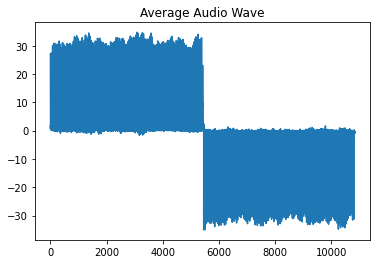

In [ ]:
import matplotlib.pyplot as plt
import wave
import sys

plt.figure(1)
plt.title("Average Audio Wave")
plt.plot(avg_training_vector)
plt.show()

## Calculating demean vector

In [ ]:
demean_training_vectors = np.subtract(training_mfcc_feature_vectors, avg_training_vector)

In [ ]:
print(demean_training_vectors.shape)
print(demean_training_vectors)

(699, 10842)
[[  4.3706598   31.67554733  21.98490762 ...   1.27014412  -4.11840559
   -0.91143867]
 [ 34.77895243  -4.34073058 -14.85750537 ...   0.37376501   2.39190498
   -1.44052917]
 [-67.96576402  33.23376467 -13.92061129 ...   4.34474341   1.46602258
   -0.49181134]
 ...
 [ 37.49946598  14.25709536   5.55277111 ...  -1.52610484   3.3384031
   -2.78972668]
 [-14.04583158  10.47855077 -49.00915784 ...  -0.12930494  -4.41712596
    1.04427089]
 [-12.14783581 -13.83903157   5.19124241 ...  -4.08411864   2.29963568
   -2.89337787]]


## Visualizing Demeaned Vectors

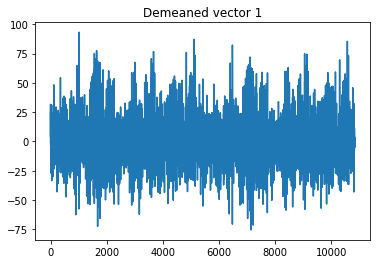

In [ ]:
plt.figure(2)
plt.title("Demeaned vector 1")
plt.plot(demean_training_vectors[0])
plt.show()

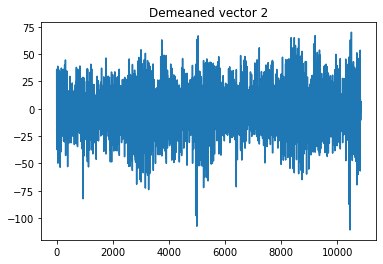

In [ ]:
plt.figure(3)
plt.title("Demeaned vector 2")
plt.plot(demean_training_vectors[1])
plt.show()

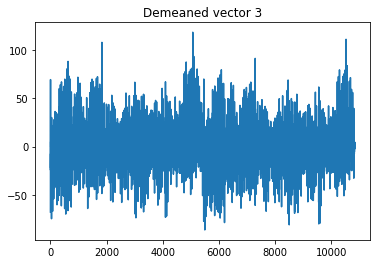

In [ ]:
plt.figure(3)
plt.title("Demeaned vector 3")
plt.plot(demean_training_vectors[2])
plt.show()

## Calculate Covariance Matrix using A^T.A

In [ ]:
print(np.transpose(demean_training_vectors).shape)

(10842, 699)


In [ ]:
covariance_matrix = np.dot(demean_training_vectors, demean_training_vectors.T)

In [ ]:
print(covariance_matrix.shape)
print(covariance_matrix[0].shape)

(699, 699)
(699,)


## Getting Eigenvectors and Eigenvalues of Covariance Matrix

In [ ]:
import scipy.linalg as la
from numpy import linalg as LA

eigenvalues, eigenvectors = LA.eig(covariance_matrix)

In [ ]:
idx = eigenvalues.argsort()[::-1]

In [ ]:
idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  45,  44,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  60,  61,  62,  63,  59,  64,
        65,  66,  67,  68,  69,  70,  71,  73,  72,  74,  75,  76,  77,
        78,  79,  81,  80,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        93,  94,  91,  92,  95,  96,  97,  98,  99, 100, 102, 101, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 113, 115, 116,
       118, 117, 119, 120, 121, 122, 124, 123, 125, 126, 127, 129, 128,
       130, 131, 133, 134, 137, 136, 135, 132, 138, 139, 142, 143, 145,
       148, 144, 147, 141, 140, 146, 149, 150, 151, 152, 153, 154, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 166, 168, 170,
       169, 171, 172, 173, 174, 175, 176, 178, 177, 179, 180, 18

In [ ]:
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

In [ ]:
print(eigenvalues.shape)
print(eigenvectors.shape)

(699,)
(699, 699)


In [ ]:
eigenvectors

array([[ 2.63731352e-02, -9.53500554e-03, -1.50836823e-02, ...,
        -3.78234737e-02,  9.64271231e-06, -7.23629286e-04],
       [ 2.90243558e-02,  1.28982949e-02,  3.34888686e-02, ...,
        -3.78234737e-02,  9.64271231e-06, -7.23629286e-04],
       [ 1.59129497e-04, -1.03465001e-01,  2.90620005e-02, ...,
        -3.78234737e-02,  9.64271231e-06, -7.23629286e-04],
       ...,
       [-4.43131038e-02, -8.07471394e-02, -3.45843856e-02, ...,
        -3.78234737e-02,  9.64271231e-06, -7.23629286e-04],
       [ 2.03927596e-02,  1.02236830e-02,  4.60290707e-03, ...,
        -3.78234737e-02,  9.64271231e-06, -7.23629286e-04],
       [ 3.08639556e-02,  1.11087534e-02, -1.58849663e-03, ...,
        -3.78234737e-02,  9.64271231e-06, -7.23629286e-04]])

In [ ]:
eigenvalues

array([ 3.61211639e+07,  3.37829118e+07,  2.65250835e+07,  2.40953637e+07,
        2.30709247e+07,  2.08050992e+07,  1.97994936e+07,  1.93318215e+07,
        1.85608908e+07,  1.73451921e+07,  1.61944758e+07,  1.55952265e+07,
        1.44896565e+07,  1.43241856e+07,  1.36450585e+07,  1.34111890e+07,
        1.28663406e+07,  1.24829815e+07,  1.20220047e+07,  1.16820721e+07,
        1.14689462e+07,  1.13347313e+07,  1.11130422e+07,  1.06331576e+07,
        1.05423333e+07,  1.03872224e+07,  1.00517212e+07,  9.92867823e+06,
        9.58994603e+06,  9.46914169e+06,  9.19828591e+06,  9.12809142e+06,
        8.79863790e+06,  8.69062665e+06,  8.57795179e+06,  8.42735898e+06,
        8.32972217e+06,  8.24835458e+06,  8.06473005e+06,  7.81244429e+06,
        7.59896967e+06,  7.53760270e+06,  7.36621035e+06,  7.18286460e+06,
        7.03378019e+06,  7.02954712e+06,  6.96051370e+06,  6.83892948e+06,
        6.66509027e+06,  6.63899803e+06,  6.42779373e+06,  6.35765014e+06,
        6.26382287e+06,  

In [ ]:
k = 12

eigenvalues = eigenvalues[:k]
print(eigenvalues)

[36121163.87027126 33782911.80501226 26525083.45002666 24095363.68578962
 23070924.70804382 20805099.162065   19799493.5526172  19331821.45972542
 18560890.83693781 17345192.13914257 16194475.81313756 15595226.48169786]


In [ ]:
eigenvectors = eigenvectors[:, :k]
print(eigenvectors)

[[ 0.02637314 -0.00953501 -0.01508368 ...  0.01550719  0.00860504
   0.02238045]
 [ 0.02902436  0.01289829  0.03348887 ... -0.00794239  0.02409924
  -0.00959321]
 [ 0.00015913 -0.103465    0.029062   ...  0.0305162  -0.07298202
   0.03017549]
 ...
 [-0.0443131  -0.08074714 -0.03458439 ... -0.0130265   0.00428012
   0.05082216]
 [ 0.02039276  0.01022368  0.00460291 ...  0.00774229 -0.00512348
   0.04165445]
 [ 0.03086396  0.01110875 -0.0015885  ... -0.01910657  0.03465275
  -0.01953691]]


In [ ]:
print(eigenvalues.shape)
print(eigenvectors.shape)

(12,)
(699, 12)


## Getting the orthogonal basis

In [ ]:
import math
u = np.dot(demean_training_vectors.T, eigenvectors) 


In [ ]:
u = np.array(u)
print(u.shape)
print(u[0].shape)
print(type(u))

(10842, 12)
(12,)
<class 'numpy.ndarray'>


## Representing each training set image vector in the linear combinations of K eigenvectors.

In [ ]:
ytrain = [] 

for vector in demean_training_vectors:
  temp = np.dot(u.T, vector)
  ytrain.append(temp)

In [ ]:
ytrain = np.array(ytrain)

In [ ]:
ytrain.shape

(699, 12)

# Working with Testing Dateset

## Find the normalized vector of testing set data by subtracting testing set vectors from average of training set vectors

In [ ]:
demean_testing_vectors = np.subtract(testing_mfcc_feature_vectors, avg_training_vector)

In [ ]:
print(demean_testing_vectors.shape)
print(demean_testing_vectors)

(300, 10842)
[[ -0.23995846 -27.13622715 -10.00296307 ...   0.70774497  -1.54159369
    1.19817051]
 [ -5.3608798   15.01274822   4.48664126 ...   1.37374811   4.45513801
   -0.10582751]
 [ 11.57075075  -2.19210256   5.22296471 ...   1.11007369   4.66394794
   -0.62620247]
 ...
 [  9.95088629   1.55359291 -19.8791488  ...   0.97814441   0.46624997
   -3.14829389]
 [-15.16833861 -41.79990726 -12.21868517 ...   0.49606955  -2.7215319
    0.57713185]
 [ 20.68212275 -22.97379774  39.75369547 ...  -2.16098291   2.58817967
    2.88352492]]


## Representing each testing set image vector in the linear combinations of K eigenvectors.

In [ ]:
ytest = [] 

for vector in demean_testing_vectors:
  temp = np.dot(u.T, vector)
  ytest.append(temp)

In [ ]:
ytest = np.array(ytest)

In [ ]:
ytest.shape

(300, 12)

# Running KMeans with the reduced dimensions found from PCA on ytrain

In [ ]:
from sklearn.cluster import KMeans
import time

In [ ]:
# K Clusters
K = 10

print('GTZAN Data Kmeans Started: ')
start_time = time.time()

# Running KMeans on images 10 times and making 10 clusters
# Initialization of centroids are done randomly
kmeans = KMeans(n_clusters=K, init='random', n_init=K).fit(ytrain)

print('GTZAN Data Kmeans  Ended: ')
print("--- %s seconds ---" % (time.time() - start_time))

# the cluster centers or centroids
clusters = kmeans.cluster_centers_

# find which points in the sample belong to which cluster
cluster_affiliations = kmeans.predict(ytrain)

print('Total Number of Clusters: ', len(clusters))
print('Clusters: ', clusters)
print('Clusters Shape: ', clusters.shape)

print('Total Number of points in all clusters: ', len(cluster_affiliations))
print('Cluster Affiliations: ', cluster_affiliations)

GTZAN Data Kmeans Started: 
GTZAN Data Kmeans  Ended: 
--- 0.7904114723205566 seconds ---
Total Number of Clusters:  10
Clusters:  [[-2.02557462e+06 -2.08650964e+06  6.04826045e+05 -1.17106332e+05
  -5.78216353e+05 -7.45160505e+03  7.67142338e+04 -1.42313570e+05
   1.11873661e+05  2.14207559e+04  3.10512540e+04 -2.55849348e+05]
 [ 5.01489677e+05 -1.59745610e+06 -1.97450856e+05  4.44745462e+05
   5.49135206e+05 -1.74660733e+05  1.16819112e+05  9.56740739e+04
  -4.15589230e+04  5.95706419e+04  1.22217981e+05  9.47052638e+04]
 [ 3.88610033e+06 -9.98661553e+05 -6.93130796e+05 -3.46453573e+05
  -2.45032194e+05  4.24320245e+05  4.48571253e+04 -3.03773286e+05
   2.19074331e+05 -7.12601901e+04 -1.46476870e+05 -2.06211209e+05]
 [-7.82979756e+05 -2.17238788e+05  9.91661173e+04  1.23639852e+05
   2.32278626e+05  9.02757682e+04 -2.42503898e+05 -7.14880345e+04
   2.01364141e+05  3.94131348e+04 -6.30340396e+04 -1.34740462e+05]
 [-1.07762281e+05 -2.27617249e+05 -1.48747543e+05 -1.49094960e+06
   2.80

# Running KMeans with the reduced dimensions found from PCA on ytest

In [ ]:
# K Clusters
K = 10

# Running KMeans on images 10 times and making 10 clusters
# Initialization of centroids are done randomly
kmeans_ytest = KMeans(n_clusters=K, init='random', n_init=K).fit(ytest)

# the cluster centers or centroids
clusters_ytest = kmeans_ytest.cluster_centers_

# find which points in the sample belong to which cluster
cluster_affiliations_ytest = kmeans_ytest.predict(ytest)

print('Total Number of Clusters: ', len(clusters_ytest))
print('Clusters: ', clusters_ytest)
print('Clusters Shape: ', clusters_ytest.shape)

print('Total Number of points in all clusters: ', len(cluster_affiliations_ytest))
print('Cluster Affiliations: ', cluster_affiliations_ytest)

Total Number of Clusters:  10
Clusters:  [[ -311233.1939003   -498857.4209548   -120345.61652623   299469.57345617
   -825532.28635675   -37457.22600369   -18697.5444601    491669.75620689
     78556.32886383   -65328.9213539   -161581.59352626   114285.24450472]
 [  698143.4370899   1900057.96381015  1242895.43367363   -77692.55039491
    333736.72044198  -213485.66487232   378036.20395697  -105518.65561804
    168762.14784141   256311.80849189   -98991.56226334   273856.90774913]
 [-2111353.55571334  -821661.3992717   -239478.66943628  -343460.33970414
   -305786.03206483  -440754.93997654   -40949.82794973  -240826.86120284
   -438059.02923238    86392.23089153   156932.87149576  -232569.69275698]
 [ 1030467.48851483   290770.49277583    91719.212551     106247.58216922
    125118.87478985   153601.94554344    28028.37978927    -8314.53384314
    159547.06277441    81399.36892717   -12646.8448966    -94321.21933023]
 [  -69354.58365705   483459.42282317  -463700.77410229  -632559.12

# Evaluating the quality of the clusters

## Checking quality of the final cluster using J
a) 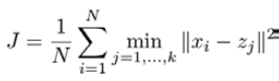

In [ ]:
# N = number of images
N = ytrain.shape[0]

# initialize sum
sum = np.zeros(ytrain.shape[1])

# x = image, z = clusters
for index, v in enumerate(ytrain):
  sum += np.linalg.norm(v - clusters[cluster_affiliations[index]]) ** 2

# calculating J
J = sum / N

# check if all elements in J are same
good = np.all(J == J[0])
print(J)
if good:
  print('Quality Good!')

[6.21264393e+12 6.21264393e+12 6.21264393e+12 6.21264393e+12
 6.21264393e+12 6.21264393e+12 6.21264393e+12 6.21264393e+12
 6.21264393e+12 6.21264393e+12 6.21264393e+12 6.21264393e+12]
Quality Good!


## Checking quality of the final cluster using Davies–Bouldin index

b) Davies–Bouldin index
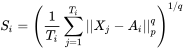

A lower Davies-Bouldin index relates to a model with better 
separation between the clusters. This index signifies the 
average ‘similarity’ between clusters, where the similarity 
is a measure that compares the distance between clusters with 
the size of the clusters themselves. Zero is the lowest possible 
score. Values closer to zero indicate a better partition.

Reference: sklearn documentation

In [ ]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(ytrain.real, cluster_affiliations.real)
print('Davies Bouldin Index Score: {}'.format(db_score))

Davies Bouldin Index Score: 2.1872803165742645


## Checking quality of the final cluster using Dunn index
c) Dunn index

It is calculated as the lowest intercluster distance (ie. the smallest distance 
between any two cluster centroids) divided by the highest intracluster distance 
(ie. the largest distance between any two points in any cluster).
The higher the value of the Dunn index, the better the aggregation. 
The number of clusters which maximizes the Dunn index is considered to be the 
optimal number of clusters k. It also has some drawbacks. As the number of 
clusters and the dimensionality of the data increase, so does the cost of computation. 
(Reference: 
1. https://en.wikipedia.org/wiki/Dunn_index 
2. https://python.engineering/dunn-index-and-db-index-cluster-validity-indices-set-1/
3. https://mayankdw.medium.com/k-means-clustering-and-dunn-index-implementaion-from-scratch-9c66573bfe90)


In [ ]:
import math

# find euclidean distance between two points 
def find_distance(point, cluster_point):
    distance = math.sqrt(np.sum(np.power(np.subtract(point, cluster_point), 2))) 
    return distance

# find lowest intercluster distance
def get_lowest_intercluster_distance(clusters):
  min_intercluster_distance = float('inf')

  for index_1, cluster_1 in enumerate(clusters):
    for index_2, cluster_2 in enumerate(clusters):
      distance = float('inf')
      
      if index_1 == 0 and index_2 == 1:
        distance = find_distance(cluster_1, cluster_2)
        min_intercluster_distance = distance
      
      else:
        if np.any(cluster_1 != cluster_2):
          distance = find_distance(cluster_1, cluster_2)
      
        if distance < min_intercluster_distance:
          min_intercluster_distance = distance
    
    return min_intercluster_distance

# find highest intracluster distance
def get_highest_intracluster_distance(v):
  max_intracluster_distance = float('inf')

  for index_1, point_1 in enumerate(v):
    for index_2, point_2 in enumerate(v):
      distance = float('inf')
      
      if index_1 == 0 and index_2 == 1:
        distance = find_distance(point_1, point_2)
        max_intracluster_distance = distance
      
      else:
        if np.any(point_1 != point_2):
          distance = find_distance(point_1, point_2)
      
        if distance > max_intracluster_distance:
          max_intracluster_distance = distance
    
    return max_intracluster_distance

# find dunn index
def dunn_index(ytrain, clusters):
  lowest_intercluster_distance = get_lowest_intercluster_distance(clusters)

  highest_intracluster_distance = get_highest_intracluster_distance(ytrain)

  return lowest_intercluster_distance/highest_intracluster_distance

dunn_index_score = dunn_index(ytrain.real, clusters)

# Print Dunn Index Score
print('Dunn Index Score: {}'.format(dunn_index_score))


Dunn Index Score: 0.3005720057198334


# Visualizing the Data

## Visualizing High Dimensional Training Set Data

In [ ]:
x = training_mfcc_feature_vectors[:, 0]
y = training_mfcc_feature_vectors[:, 1]
z = training_mfcc_feature_vectors[:, 2]

In [ ]:
import matplotlib.pyplot as plt

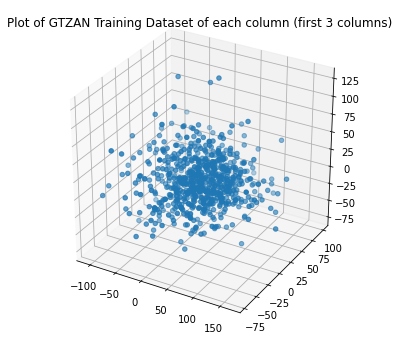

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
ax.set_title("Plot of GTZAN Training Dataset of each column (first 3 columns)")

plt.show()

## Visualizing Low Dimensional Training Set Data

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
x = ytrain[:, 0].real
y = ytrain[:, 1].real
z = ytrain[:, 2].real

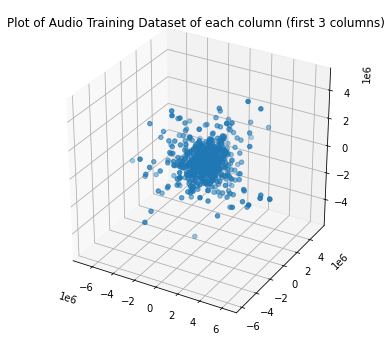

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
ax.set_title("Plot of Audio Training Dataset of each column (first 3 columns)")

plt.show()

## Visualizing Testing Set Data

In [ ]:
x = ytest[:, 0].real
y = ytest[:, 1].real
z = ytest[:, 2].real

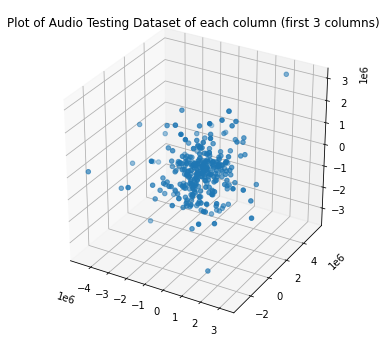

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
ax.set_title("Plot of Audio Testing Dataset of each column (first 3 columns)")

plt.show()

## Plotting the Clusters found from Kmeans (ytrain)

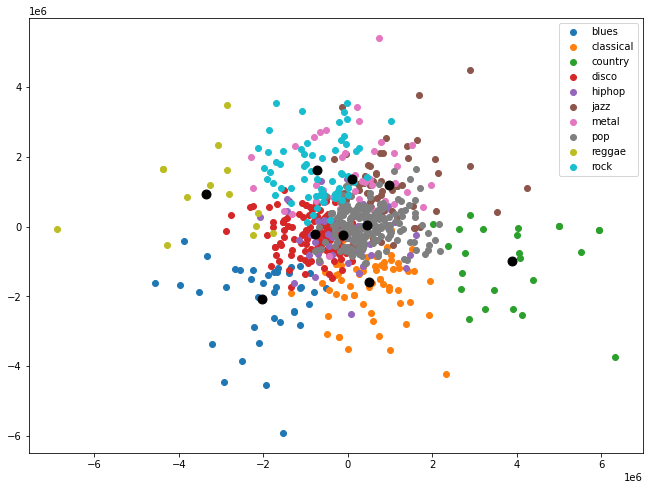

In [ ]:
unique_labels = np.unique(cluster_affiliations)
 
#plotting the results:
fig = plt.figure(figsize=(11, 8)) 
for i in unique_labels:
    plt.scatter(ytrain.real[cluster_affiliations == i , 0] , ytrain.real[cluster_affiliations == i , 1] , label = folders[i])
plt.scatter(clusters[:,0] , clusters[:,1] , s = 80, color = 'k')
ax.set_title("2D Plot of Clusters found from KMeans (ytest)")
plt.legend()
plt.show()

## Plotting the Clusters found from Kmeans (ytest)

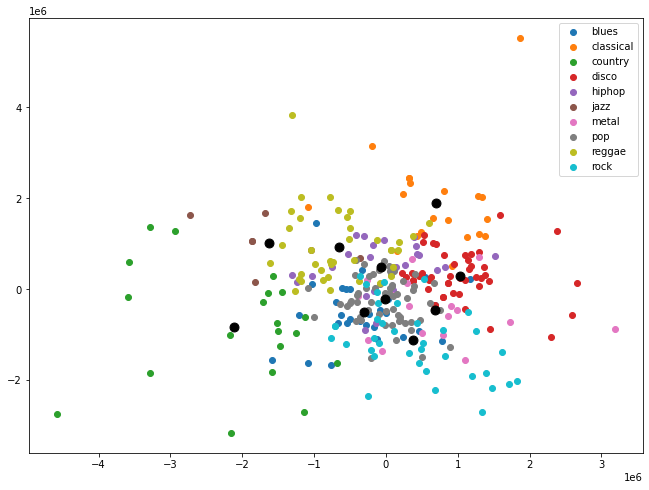

In [ ]:
unique_labels = np.unique(cluster_affiliations_ytest)
 
#plotting the results:
fig = plt.figure(figsize=(11, 8)) 
for i in unique_labels:
    plt.scatter(ytest.real[cluster_affiliations_ytest == i , 0] , ytest.real[cluster_affiliations_ytest == i , 1] , label = folders[i])
plt.scatter(clusters_ytest[:,0] , clusters_ytest[:,1] , s = 80, color = 'k')
ax.set_title("2D Plot of Clusters found from KMeans (ytest)")
plt.legend()
plt.show()

## 3D Visualization of the Clusters (ytrain)

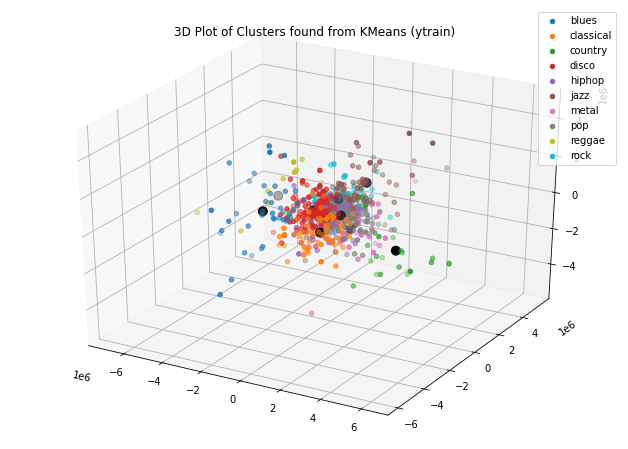

In [ ]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
unique_labels = np.unique(cluster_affiliations)

#plotting the results:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

for i in unique_labels:
  ax.scatter(ytrain.real[cluster_affiliations == i, 0], ytrain.real[cluster_affiliations == i, 1], ytrain.real[cluster_affiliations == i, 2], label = genres[i])
ax.scatter(clusters[:, 0] , clusters[:, 1], clusters[:,2], s = 80, color = 'k')
ax.set_title("3D Plot of Clusters found from KMeans (ytrain)")

plt.legend()
plt.show()

## 3D Visualization of the Clusters (ytest)

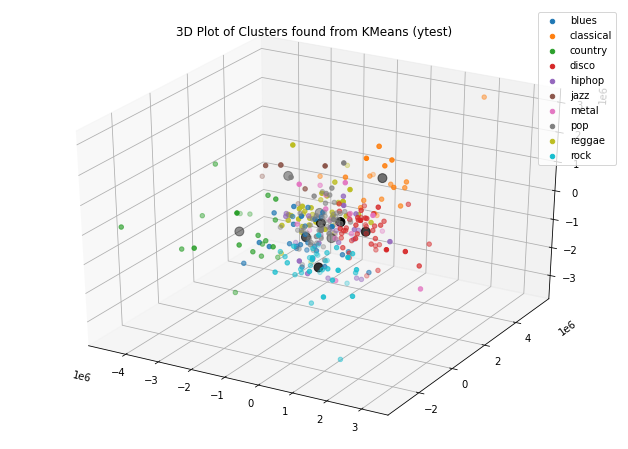

In [ ]:
unique_labels = np.unique(cluster_affiliations_ytest)

#plotting the results:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

for i in unique_labels:
    ax.scatter(ytest.real[cluster_affiliations_ytest == i, 0], ytest.real[cluster_affiliations_ytest == i, 1], ytest.real[cluster_affiliations_ytest == i, 2], label = genres[i])
ax.scatter(clusters_ytest[:, 0] , clusters_ytest[:, 1], clusters_ytest[:,2], s = 80, color = 'k')
ax.set_title("3D Plot of Clusters found from KMeans (ytest)")

plt.legend()
plt.show()

# Performing SVM

## Performing SVM on original datasets

In [ ]:
from sklearn import svm
from sklearn import metrics

In [ ]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf')

print('Start Time for SVM on GTZAN dataset - original dataset - full dataset')
start_time = time.time()

#Train the model using the training sets
clf.fit(training_mfcc_feature_vectors, training_labels)

#Predict the response for test dataset
y_pred = clf.predict(testing_mfcc_feature_vectors)

print('End Time for SVM on GTZAN dataset - original dataset - full dataset')
print("--- %s seconds ---" % (time.time() - start_time))

Start Time for SVM on GTZAN dataset - original dataset - full dataset


KeyboardInterrupt: ignored

### Calculating Accuracy Score of original datasets

In [ ]:
#Import scikit-learn metrics module for accuracy calculation

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(testing_labels, y_pred, normalize=True))

### Calculating F-1 Score of original datasets

In [ ]:
print("Precision:", metrics.f1_score(testing_labels, y_pred, average='macro'))

Precision: 0.16108497509197175


## Performing SVM on the reduced datasets

In [ ]:
print('Start Time for SVM on GTZAN dataset - reduced dataset')
start_time = time.time()

#Create a svm Classifier
clf = svm.SVC(kernel='rbf')

#Train the model using the training sets
clf.fit(ytrain, training_labels)

#Predict the response for test dataset
y_pred = clf.predict(ytest)

print('End Time for SVM on GTZAN dataset - reduced dataset')
print("--- %s seconds ---" % (time.time() - start_time))

Start Time for SVM on GTZAN dataset - reduced dataset
End Time for SVM on GTZAN dataset - reduced dataset
--- 0.07834410667419434 seconds ---


### Calculating Accuracy Score of reduced datasets

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(testing_labels, y_pred, normalize=True))

Accuracy: 0.17


### Calculating F-1 Score of reduced datasets

In [ ]:
print("Precision:", metrics.f1_score(testing_labels, y_pred, average='macro'))

Precision: 0.16247359890340976
